# Image Preprocessing / 실행 X

In [ ]:
def remove_transparency(source, bg_color):
  source_img = source[:, :, :3]
  source_mask = source[:, :, 3] * (1/255.)
  source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)

  bg_mask = 1.0 - source_mask

  bg_part = (bg_color * (1/255.0) * (bg_mask))
  source_part = (source_img * (1/255.0) * (source_mask))

  return np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0))

In [ ]:
def get_images(img_dir, height=64, width=64):
  num = 0

  img_list = glob.glob(img_dir)
  images = []

  for img_path in img_list:
    img = cv2.imread(img_path, -1)

    if img.shape[2] == 4:
      img = remove_transparency(img, 255)
    
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (height, width))
    cv2.imwrite(f'/content/drive/MyDrive/ECGAN_Project/face_image/Convert_image/{num}.png', img)
    num += 1
    print(num)
    # images.append(img)

  # images = np.asarray(images)
  # # images = torch.from_numpy(images)
  # # cv2.imwrite(f'{num}.jpg', images)
  # # num += 1
  # return images

# Import Lib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import os
import random
import cv2
import glob
from IPython.display import HTML
from google.colab import files
from PIL import Image

# Setting Hyperparamerters

In [ ]:
### ImageFolder
image = "/content/drive/MyDrive/ECGAN_Project/face_image/Emoji_image"

### Batch Size
batch_size = 8

### result size
image_size = 64

### image channel
image_ch = 3  # nc

### latent vector (예: Generator의 입력 값 크기)
latent = 100  # nz

### Generator를 통과하는 특징 데이터들의 채널 크기
ngf = 64

### Discriminator를 통과하는 특징 데이터들의 채널 크기
ndf = 64

### n_epoch
n_epoch = 200

### learing rate
lr = 0.0002

### Beta1
beta1 = 0.5

ngpu = 1

# Create Dataset

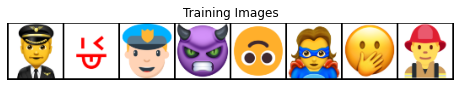

In [ ]:
# 우리가 설정한 대로 이미지 데이터셋을 불러와 봅시다
# 먼저 데이터셋을 만듭니다
dataset = dset.ImageFolder(root=image,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.CenterCrop(image_size),
                               T.ToTensor(),
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader를 정의해봅시다
ImageDataset = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(ImageDataset))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# 가중치 초기화

* DCGAN 논문에서는 평균이 0, 분산이 0.02인 정규분포를 이용해, 구분자와 생성자 모두 무작위 초기화를 진행하는 것이 좋다고 말한단.

* weights_init 함수는 매개변수로 모델을 입력받아, 모든 합성곱 계층, 전치 합성곱 계층, 배치 정규화 계층을, 위에서 말한 조건대로 가중치를 다시 초기화 시킨다.

* 이 함수는 모델이 만들어지지 마자 바로 적용을 시키게 된다.

In [ ]:
# Generator와 Discriminator에 적용시킬 custom weights_init func
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

# Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(
        nn.ConvTranspose2d(latent, ngf*8, kernel_size=4, stride=1, padding=0),# , bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(),
        # 위 계층을 통과한 데이터의 크기 => (ngf*8) X 4 X 4 => 512 X 4 X 4

        nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1),# , bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(),
        # 위 계층을 통과한 데이터의 크기 => (ngf*4) X 8 X 8 => 256 X 8 X 8

        nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1),# , bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(),
        # 위 계층을 통과한 데이터의 크기 => (ngf*2) X 16 X 16 => 128 X 16 X 16

        nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1),# , bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(),
        # 위 계층을 통과한 데이터의 크기 => (ngf) X 32 X 32 => 64 X 32 X 32
        
        nn.ConvTranspose2d(ngf, image_ch, 4, 2, 1),# , bias=False),
        nn.Tanh()
        # 위 계층을 통과한 데이터의 크기 => (nc) X 64 X 64 => 3 X 64 X 64
    )


  def forward(self, input):
      return self.model(input)

In [ ]:
G = Generator(ngpu).to(device)
G.apply(weights_init)
print(G)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


# Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(
        # 입력 데이터의 크기 (nc) X 64 X 64 => 3 X 64 X 64
        nn.Conv2d(image_ch, ndf, kernel_size=4, stride=2, padding=1), #, bias=False),
        nn.LeakyReLU(0.2),
        # 위 계층을 통과한 데이터의 크기 => (ndf) X 32 X 32 => 64 X 32 X 32

        nn.Conv2d(ndf, ndf*2, 4, 2, 1) #,  bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2),
        # 위 계층을 통과한 데이터의 크기 => (ndf*2) X 16 X 16 => 128 X 16 X 16

        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), #, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2),
        # 위 계층을 통과한 데이터의 크기 => (ndf*4) X 8 X 8 => 256 X 8 X 8

        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1), #, bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2),
        # 위 계층을 통과한 데이터의 크기 => (ndf*8) X 4 X 4 => 512 X 4 X 4

        nn.Conv2d(ndf*8, 1, 4, 1, 0), #, bias=False),
        nn.Sigmoid()

    )
  

  def forward(self, input):
    return self.model(input)

In [ ]:
D = Discriminator(ngpu).to(device)
D.apply(weights_init)
print(D)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


# Loss Func

* 손실함수로는 Binary Cross Entropy loss(BCELoss)를 사용.

In [ ]:
# BCELoss 함수의 인스턴스 생성
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성
noise = torch.randn(64, latent, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨 설정
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 설정
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

In [ ]:
## 학습과정

# 학습상태를 체크하기 위해 손실 값들을 저장
img_list = []
G_loss = []
D_loss = []
iters = 0

print("Starting Training Loop...")
# epoch 반복
for epoch in range(n_epoch):
  # 한 epoch 내에서 배치 반복
  for i, data in enumerate(ImageDataset, 0):
    ################################
    # (1) D 신경망을 업데이트합니다.: log(D(x)) + log(1 - D(G(z)))를 최대화 한다.
    ################################
    ## 진짜 데이터들로 학습한다.
    """Pytorch에서는 gradients 값들을 추후에 backward를 해줄때 계속 더해주기 때문이다.
    역전파 과정을 수행할 때 매번 gradient를 더해주는 것으로 설정이 되어있다. 즉, 한 번이 학습이 완료되면
    (iteration이 한 번 끝나면) gradients를 항상 0으로 만들어준다. 초기화 해주지 않으면 학습이 정상적으로 이루어지지 않는다."""
    D.zero_grad()
    real_cpu = data[0].to(device)
    # print(real_cpu.shape)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # 진짜 데이터들로 이루어진 배치를 D에 통과시칸다.
    output = D(real_cpu).view(-1)
    # 손실 값을 구한다.
    errD_real = criterion(output, label)
    # 역전파의 과정에서 변화도를 계산한다.
    errD_real.backward()
    D_x = output.mean().item()

    ## 가짜 데이터들로 학습을 한다.
    # 생성자에 사용할 잠재공간 벡터를 생성한다.
    noise = torch.randn(b_size, latent, 1, 1, device=device)
    # G를 이용해 가짜 이미지를 생성한다.
    fake = G(noise)
    label.fill_(fake_label)
    # D를 이용해 데이터의 진위를 판별한다.
    output = D(fake.detach()).view(-1)
    # D의 손실 값을 계산한다.
    errD_fake = criterion(output, label)
    # 역전파를 통해 변화도를 계산한다. 이 때 앞서 구한 변화도에 더해준다.
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # 가짜 이미지와 진짜 이미지 모두에서 구한 손실 값을 더한다.
    # 이 때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 reporting할 때 사용한다.
    errD = errD_real + errD_fake
    # D를 업데이트한다.
    optimizerD.step()

    ##################################
    # (2) G 신경망을 업데이트 한다. : log(D(G(z)))를 최대화 한다.
    ##################################
    G.zero_grad()
    label.fill_(real_label)  # G의 손실 값을 구하기 위해 진짜 라벨을 이용한다.
    # 방금 D를 업데이트 했기 때문에 D에 다시 가짜 데이터를 통과시킨다.
    # 이 때 G는 업데이트 되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실 값과 다른 값이 나오게 된다.
    output = D(fake).view(-1)
    # G의 손실값을 구한다.
    errG = criterion(output, label)
    # G의 변화도를 구한다.
    errG.backward()
    D_G_z2 = output.mean().item()
    # G를 업데이트 한다.
    optimizerG.step()

    # 훈련 상태를 출력한다.
    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
      % (epoch, n_epoch, i, len(ImageDataset),
          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    # 이 후 그래프를 그리기 위해 손실 값들을 저장한다.
    G_loss.append(errG.item())
    D_loss.append(errD.item())

    # fixed_noise를 통과시킨 G의 출력 값을 저장한다.
    if (iters % 500 == 0) or ((epoch == n_epoch-1) and (i == len(ImageDataset)-1)):
      with torch.no_grad():
        fake = G(noise).detach()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    iters += 1

Starting Training Loop...
[0/200][0/614]	Loss_D: 2.3913	Loss_G: 7.9347	D(x): 0.3849	D(G(z)): 0.6460 / 0.0005
[0/200][50/614]	Loss_D: 0.0044	Loss_G: 30.4278	D(x): 0.9957	D(G(z)): 0.0000 / 0.0000
[0/200][100/614]	Loss_D: 0.0027	Loss_G: 32.0559	D(x): 0.9973	D(G(z)): 0.0000 / 0.0000
[0/200][150/614]	Loss_D: 0.0882	Loss_G: 9.6735	D(x): 0.9301	D(G(z)): 0.0006 / 0.0011
[0/200][200/614]	Loss_D: 0.1404	Loss_G: 6.8100	D(x): 0.9149	D(G(z)): 0.0003 / 0.0072
[0/200][250/614]	Loss_D: 0.0548	Loss_G: 7.5728	D(x): 0.9565	D(G(z)): 0.0090 / 0.0042
[0/200][300/614]	Loss_D: 0.3471	Loss_G: 5.5544	D(x): 0.8033	D(G(z)): 0.0408 / 0.0114
[0/200][350/614]	Loss_D: 0.0871	Loss_G: 7.2180	D(x): 0.9966	D(G(z)): 0.0761 / 0.0015
[0/200][400/614]	Loss_D: 0.0718	Loss_G: 4.2859	D(x): 0.9795	D(G(z)): 0.0467 / 0.0280
[0/200][450/614]	Loss_D: 0.8825	Loss_G: 3.6466	D(x): 0.8673	D(G(z)): 0.3236 / 0.0478
[0/200][500/614]	Loss_D: 1.1390	Loss_G: 11.5557	D(x): 0.9877	D(G(z)): 0.5686 / 0.0000
[0/200][550/614]	Loss_D: 0.1157	Loss_G:

In [ ]:
## Save Generator Model
save_dir = '/content/drive/MyDrive/AI Play/DCGAN'
torch.save(G, 'Generator.pt') # 변경된 매개변수 값 넣어서 구분 짓기
torch.save(G.state_dict(), 'Generator_state_dict.pt')

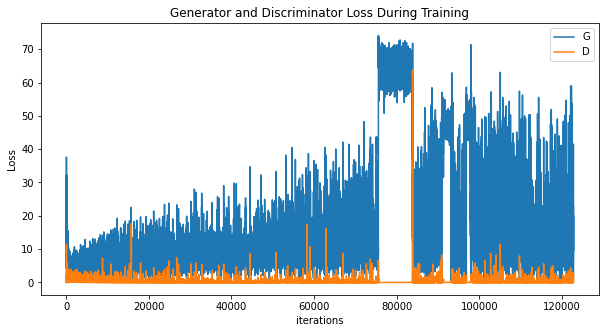

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
test1 = []
trans = T.ToPILImage()
for idx, image in enumerate(img_list): 
  torchvision.utils.save_image(image, f'/content/drive/MyDrive/AI Play/DCGAN/generator_image/{idx}.png')

In [ ]:
test = []
for i in img_list:
  idx = i.cpu().data.numpy()
  test.append(idx)
  fig = plt.figure(figsize=(8, 8))
  plt.axis("off")
  ims = [[plt.imshow(np.transpose(i, (1,2,0)))] for i in test]

In [ ]:
new_noise = torch.randn(b_size, latent, 1, 1, device=device)

In [ ]:
new_emoji = G(new_noise)

In [ ]:
torchvision.utils.save_image(new_emoji, './test.png')